In [1]:
%matplotlib inline

In [2]:
# Reguired libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import cm as basemap_cm
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import ranksums, ttest_ind
from scipy.spatial import ConvexHull
from datetime import datetime
from calendar import month_abbr, month_name
from netCDF4 import date2num, num2date

# For temporary display of existing figures
from IPython.display import Image

# RASM lib plotting utilities
from rasmlib.calendar import dpm
from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons

# Set some general plotting values
fontsize = 7
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

fill_color = (0.9, 0.9, 0.9)


In [3]:
rasm_sims = ['$RASM_{CONTROL}$', '$RASM_{RSI}$', '$RASM_{RSH}$']
rasm_cpl_sims = ['$RASM-CPL_{CONTROL}$', '$RASM-CPL_{RSI}$', '$RASM-CPL_{RSH}$']

# daily = True
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_masks'] = '/raid2/jhamman/projects/RASM/data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'

# RASM run files used in this analysis
ncfiles['$RASM_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/lnd/monthly_mean_timeseries/R1010RBRbaaa01a.vic.hmm.197909-201412.nc'
ncfiles['$RASM_{RSI}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/lnd/monthly_mean_timeseries/R1010RBRbrsi01a.vic.hmm.197909-201412.nc'
ncfiles['$RASM_{RSH}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/lnd/monthly_mean_timeseries/R1010RBRbrsh01a.vic.hmm.197909-201412.nc'

ncfiles['$RASM-CPL_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.hmm.197909-201412.nc'
ncfiles['$RASM-CPL_{RSI}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsi01a/cpl/monthly_mean_timeseries/R1010RBRbrsi01a.cpl.hmm.197909-201412.nc'
ncfiles['$RASM-CPL_{RSH}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbrsh01a/cpl/monthly_mean_timeseries/R1010RBRbrsh01a.cpl.hmm.197909-201412.nc'

# Comparison datasets

# Spatio-temporal - monthly
ncfiles['era_monthly_ts1'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/wrf-197909-201212.era_i.nc'
ncfiles['era_monthly_ts2'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/met_em-197909-201212.nc'
ncfiles['era_monthly_ts3'] = '/raid2/jhamman/projects/RASM/data/compare/era-interim/era_water_vars.1979-2014.nc'
ncfiles['merra_monthly_ts1'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_lnd_Nx.197901-201312.SUB.wr50a.nc'
ncfiles['merra_monthly_ts2'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/monthly/MERRA.prod.assim.tavgM_2d_rad_slv_Nx.1979-2015.SUB.wr50a.nc'
ncfiles['cru_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/cru_ts3.21/cru_ts3.21.1901.2012_wr50a.nc'
ncfiles['sheffield_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/sheffield2006/sheffield2006_wr50a.mm.nc'
ncfiles['adam_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/adam2003/adam2003_wr50a.mm.nc'
ncfiles['gfluxnet_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/GlobalFluxNet/GlobalFluxNet.wr50a.1982-2011.nc'
ncfiles['globalbedo_monthly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/GlobAlbedo/GlobAlbedo.1998-2011.mosaic.wr50a.nc'
# Spatio-temporal - weekly
# ncfiles['nsidc_weekly_ts'] = '/raid2/jhamman/projects/RASM/data/compare/nsidc_snowcover/nsidc_snowcover_V4_wr50a.nc'

# Spatio-temporal - daily
# if daily:
#     ncfiles['merra_daily_ts'] = '/raid2/jhamman/projects/RASM/data/compare/MERRA/daily/MERRA.prod.assim.tavg1_2d_lnd_Nx.1981-2010.SUB.wr50a.nc'

# Timeseries - subdaily

start='1979-09-01'
end='2014-12-31'

simple_start = '1980-01-01'
simple_end = '2014-12-31'

calendars = {}
calendars['$NSIDC$'] = 'standard'
calendars['$RASM_{ERA}$'] = 'noleap'
calendars['$RASM_{CFSR}$'] = 'noleap'
calendars['$RASM_{CONTROL}$'] = 'noleap'
calendars['$RASM_{RSI}$'] = 'noleap'
calendars['$RASM_{RSH}$'] = 'noleap'
calendars['$VIC_{S2006}$'] = 'standard'
calendars['$MERRA$'] = 'standard'
calendars['$ERA$'] = 'standard'

In [4]:
ncdata = {}
for k, v in ncfiles.items():
    try:
        print(k)
        ncdata[k] = xr.open_dataset(v)
        if 'time' in ncdata[k]:
            sorts = np.argsort(ncdata[k].time.to_index().to_julian_date())
            if not all(sorts == np.arange(len(sorts))):
                ncdata[k].load()
                ncdata[k] = ncdata[k].isel(time=sorts)
    except:
        print(k, '<---unable to decode time!', )
        ncdata[k] = xr.open_dataset(v, decode_times=False)
ncdata['gfluxnet_monthly_ts']['time'] = pd.date_range('1982-01-01', '2011-12-01', freq='MS')

# Rename variables in datasets as necessary
name_dicts = {'era_monthly_ts1': {'rsus': 'Swup',
                                  'rsds': 'Swin',
                                  'rlus': 'Lwup',
                                  'rlds': 'Lwin',
                                  'hfss': 'Senht',
                                  'hfls': 'Latht',
                                  'snow_depth': 'Swq',
                                  'precip_tot': 'Precipitation',
                                  'LW_deac_net': 'Lwnet',
                                  'SW_deac_net': 'Swnet',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts2': {'T_2m': 'Tair',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_monthly_ts3': {'tp': 'Precipitation',
                                  'e': 'Evap',
                                  'ro': 'Runoff'},
              'sheffield_monthly_ts':{'tas': 'Tair',
                                      'prcp': 'Precipitation'},
              'merra_monthly_ts1': {'prectot': 'Precipitation',
                                    'runoff': 'Runoff',
                                    'baseflow': 'Baseflow',
                                    'shland': 'Senht',
                                    'lhland': 'Latht',
                                    'snomas': 'Swq',
                                    'evland': 'Evap',
                                    'lwland': 'Lwnet',
                                    'swland': 'Swnet'},
              'merra_monthly_ts2': {'lwgem': 'Lwup',
                                    'swgdn': 'Swin',
                                    'swgnt': 'Swnet',
                                    'lwgnt': 'Lwnet',
                                    't2m': 'Tair',
                                   },
              'cru_monthly_ts': {'tmp': 'Tair',
                                 'pre': 'Precipitation'},
              'adam_monthly_ts': {'Precip': 'Precipitation'},
              'gfluxnet_monthly_ts': {'EnsembleHcor_May12': 'Senht',
                                      'EnsembleLEcor_May12': 'Latht'},
              'globalbedo_monthly_ts': {'albedo': 'calc_albedo'}
              }

for k, v in ncdata.items():
    if k in name_dicts:
        print(k)
        v.rename(name_dicts[k], inplace=True)

merra_monthly_ts2
$RASM-CPL_{RSI}$
$RASM_{CONTROL}$


/home/raid2/jhamman/projects/RASM/src/xarray/xarray/conventions.py:386: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


$RASM_{CONTROL}$ <---unable to decode time!
rasm_domain
$RASM-CPL_{CONTROL}$
$RASM_{RSH}$
$RASM_{RSH}$ <---unable to decode time!
era_monthly_ts1
merra_monthly_ts1
rasm_masks
era_monthly_ts3
sheffield_monthly_ts
cru_monthly_ts
adam_monthly_ts
$RASM-CPL_{RSH}$
globalbedo_monthly_ts
globalbedo_monthly_ts <---unable to decode time!
$RASM_{RSI}$
$RASM_{RSI}$ <---unable to decode time!
era_monthly_ts2
gfluxnet_monthly_ts
gfluxnet_monthly_ts <---unable to decode time!
merra_monthly_ts2
sheffield_monthly_ts
era_monthly_ts1
merra_monthly_ts1
era_monthly_ts3
cru_monthly_ts
adam_monthly_ts
globalbedo_monthly_ts
era_monthly_ts2
gfluxnet_monthly_ts


In [5]:
re = 6.37122e6
# Add variables or adjust units of datasets if ncessary

# RASM
ncdata['rasm_domain']['area'] *= re * re  # m2
for r in rasm_sims:
    ncdata[r]['calc_albedo'] = 1 - (ncdata[r]['Swnet'] / ncdata[r]['Swin'])
    ncdata[r]['Swup'] = ncdata[r]['Swin'] - ncdata[r]['Swnet']
    ncdata[r]['Lwup'] = ncdata[r]['Lwin'] - ncdata[r]['Lwnet']
    ncdata[r]['runoff_tot'] = ncdata[r]['Runoff'] + ncdata[r]['Baseflow']
    ncdata[r]['Radnet'] = ncdata[r]['Swnet'] + ncdata[r]['Lwnet']
    ncdata[r]['Radin'] = ncdata[r]['Swin'] + ncdata[r]['Lwin']
    ncdata[r]['runoff_ratio'] = ncdata[r]['runoff_tot'] / ncdata[r]['Precipitation']
    ncdata[r]['bowen_ratio'] = ncdata[r]['Senht'] / ncdata[r]['Latht']
    ncdata[r]['evap_frac'] = ncdata[r]['Latht'] / (ncdata[r]['Latht'] + ncdata[r]['Senht'])
    ncdata[r]['P-E'] = ncdata[r]['Precipitation'] - ncdata[r]['Evap']
    ncdata[r]['tgrad'] = ncdata[r]['Tair'] - ncdata[r]['Tsoil'].sel(depth=0).drop('depth')
    
    
# sheffield
ncdata['sheffield_monthly_ts']['Tair'] -= 273.15
ncdata['sheffield_monthly_ts']['Precipitation'] *= 86400 

# ERA-Interim
ncdata['era_monthly_ts1']['calc_albedo'] = ncdata['era_monthly_ts1']['Swup'] / ncdata['era_monthly_ts1']['Swin']
ncdata['era_monthly_ts1']['Swnet'] = ncdata['era_monthly_ts1']['Swin'] - ncdata['era_monthly_ts1']['Swup']
ncdata['era_monthly_ts1']['Lwnet'] = ncdata['era_monthly_ts1']['Lwin'] - ncdata['era_monthly_ts1']['Lwup']
ncdata['era_monthly_ts1']['Radnet'] = ncdata['era_monthly_ts1']['Swnet'] + ncdata['era_monthly_ts1']['Lwnet']
ncdata['era_monthly_ts1']['Radin'] = ncdata['era_monthly_ts1']['Swin'] + ncdata['era_monthly_ts1']['Lwin']
ncdata['era_monthly_ts1']['bowen_ratio'] = ncdata['era_monthly_ts1']['Senht'] / ncdata['era_monthly_ts1']['Latht']
ncdata['era_monthly_ts1']['evap_frac'] = 1 / (1 + ncdata['era_monthly_ts1']['bowen_ratio'])
for var in ('Runoff', 'Precipitation'):
    ncdata['era_monthly_ts3'][var] *= 1000.
ncdata['era_monthly_ts3']['Evap'] *= -1000.
ncdata['era_monthly_ts3'] = ncdata['era_monthly_ts3'].resample('MS', how='mean', dim='time')
ncdata['era_monthly_ts3']['runoff_tot'] = ncdata['era_monthly_ts3']['Runoff']
ncdata['era_monthly_ts3']['runoff_ratio'] = ncdata['era_monthly_ts3']['runoff_tot'] / ncdata['era_monthly_ts3']['Precipitation']
ncdata['era_monthly_ts3']['P-E'] = ncdata['era_monthly_ts3']['Precipitation'] - ncdata['era_monthly_ts3']['Evap']
ncdata['era_monthly_ts3'].drop(['nv4', 'xc_bnds', 'yc_bnds'])


# MERRA
ncdata['merra_monthly_ts1']['Precipitation'] *= 86400 
ncdata['merra_monthly_ts1']['Runoff'] *= 86400 
ncdata['merra_monthly_ts1']['Baseflow'] *= 86400 
ncdata['merra_monthly_ts1']['Evap'] *= 86400 
ncdata['merra_monthly_ts1']['runoff_tot'] = ncdata['merra_monthly_ts1']['Runoff'] + ncdata['merra_monthly_ts1']['Baseflow']
ncdata['merra_monthly_ts1']['runoff_ratio'] = ncdata['merra_monthly_ts1']['runoff_tot'] / ncdata['merra_monthly_ts1']['Precipitation']
ncdata['merra_monthly_ts1']['Radnet'] = ncdata['merra_monthly_ts1']['Lwnet'] + ncdata['merra_monthly_ts1']['Swnet']
ncdata['merra_monthly_ts1']['bowen_ratio'] = ncdata['merra_monthly_ts1']['Senht'] / ncdata['merra_monthly_ts1']['Latht']
ncdata['merra_monthly_ts1']['evap_frac'] = 1 / (1 + ncdata['merra_monthly_ts1']['bowen_ratio'])
ncdata['merra_monthly_ts1']['P-E'] = ncdata['merra_monthly_ts1']['Precipitation'] - ncdata['merra_monthly_ts1']['Evap']
ncdata['merra_monthly_ts2']['calc_albedo'] = 1 - (ncdata['merra_monthly_ts2']['Swnet'] / ncdata['merra_monthly_ts2']['Swin'])
ncdata['merra_monthly_ts2']['Lwin'] = ncdata['merra_monthly_ts2']['Lwup'] + ncdata['merra_monthly_ts2']['Lwnet']
ncdata['merra_monthly_ts2']['Swup'] = ncdata['merra_monthly_ts2']['Swin'] - ncdata['merra_monthly_ts2']['Swnet']
ncdata['merra_monthly_ts2']['Radin'] = ncdata['merra_monthly_ts2']['Swin'] + ncdata['merra_monthly_ts2']['Lwin']
ncdata['merra_monthly_ts2']['Tair'] -= 273.15

# Global Fluxnet
ncdata['gfluxnet_monthly_ts']['Senht'] *= (1.0e6) / 86400.  # "MJoule*m-2*d-1" --> "W*m-2"
ncdata['gfluxnet_monthly_ts']['Latht'] *= (1.0e6) / 86400.  # "MJoule*m-2*d-1" --> "W*m-2"
ncdata['gfluxnet_monthly_ts']['bowen_ratio'] = ncdata['gfluxnet_monthly_ts']['Senht'] / ncdata['gfluxnet_monthly_ts']['Latht']
ncdata['gfluxnet_monthly_ts']['evap_frac'] = 1 / (1 + ncdata['gfluxnet_monthly_ts']['bowen_ratio'])

In [6]:
ds_prec = xr.open_dataset('../data/wb_depth_timeseries_by_mask.nc')
prec = ds_prec.sel(mask='central_arctic_land', dataset='$RASM_{CONTROL}$')['Precipitation'].to_series()

In [7]:
ds_prec

<xarray.Dataset>
Dimensions:        (dataset: 3, mask: 4, time: 424)
Coordinates:
  * time           (time) datetime64[ns] 1979-09-01 1979-10-01 1979-11-01 ...
  * mask           (mask) object 'serreze_land' 'serreze_ocean' ...
  * dataset        (dataset) object '$RASM_{CONTROL}$' '$RASM_{RSI}$' ...
Data variables:
    Evaporation    (dataset, mask, time) float64 -0.7441 -0.1771 -0.01222 ...
    Runoff         (dataset, mask, time) float64 0.3622 0.182 0.05304 ...
    Precipitation  (dataset, mask, time) float64 1.618 1.29 1.032 0.8286 ...

In [8]:
prec_q = prec.resample('QS-Oct').sum()
prec_q = prec_q[prec_q.index.month == 10]

prec_q.std()

0.1715765346592298

In [9]:
prec_years = OrderedDict()
prec_years['normal'] = prec_q[(prec_q < (prec_q.mean() + prec_q.std() / 2)) & (prec_q > (prec_q.mean() - prec_q.std() / 2))].index.year
prec_years['low'] = prec_q[prec_q > (prec_q.mean() + prec_q.std())].index.year
prec_years['high'] = prec_q[prec_q < (prec_q.mean() - prec_q.std())].index.year


In [11]:
swin_thresh = 25.
# masked_albedo = {}
albedo_t_slice = slice('1998-01-01', '2007-12-31')
era_sw_in = ncdata['era_monthly_ts1']['Swin'].sel(time=albedo_t_slice)
invalid = era_sw_in.values < swin_thresh
for r in rasm_sims:
    temp = ncdata[r]['calc_albedo'].sel(time=albedo_t_slice)
    temp.values[invalid] = np.nan

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [ ]:
sm = season_mean(temp, calendar='noleap')
plt.pcolormesh(np.ma.masked_invalid(sm.sel(season='DJF').values), cmap='Spectral_r', vmin=0, vmax=1)
plt.title(r)
plt.colorbar()

In [11]:
# Setup rasmlib plotting
wr50a_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['rasm_domain']['xc'].values,
                      lats=ncdata['rasm_domain']['yc'].values)
ncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])
spatial_plot_mask = ncdata['rasm_masks']['mask_active_land'].values < 0.9

In [12]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
def colorbar_index(ncolors, cmap, ticklabels=None):
    cmap = cmap_discretize_2(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, shrink=cbar_shrink, pad=0.01)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    if ticklabels is None:
        colorbar.set_ticklabels(range(ncolors))
    else:
        colorbar.set_ticklabels(ticklabels)
    return colorbar

def cmap_discretize_2(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [13]:
def plot2(plot_data,
          cmap='Spectral_r',
          amap='RdBu_r',
          ylabels=None,
          titles=('DJF', 'MAM', 'JJA', 'SON', 'ANNUAL'),
          suptitle=None,
          cbar_label='',
          abar_label='',
          vmin=None,
          vmax=None,
          amin=None,
          amax=None,
          cbar_extend='neither',
          abar_extend='neither',
          stack_cbars=False,
          map_obj=default_map,
          anom_hatching=None):
    """"""
    ncols = 5
    nrows = 3
    
    # Make sure plot_data is the right size
    grid_shape = map_obj.xi.shape
    assert(map_obj.xi.shape == map_obj.yi.shape)
    assert(map_obj.xi.shape == plot_data.shape[2:])
    assert(plot_data.shape[:2] == (nrows, ncols))
    
    # set data ranges
    if vmin is None:
        vmin = plot_data[:2].min()
    if vmax is None:
        vmax = plot_data[:2].max()
    if amin is None:
        amin = plot_data[2].min()
    if amax is None:
        amax = plot_data[2].max()
    
    # Set colorbar norms and ticks
    assert(type(cmap) == str)
    cn = 10
    cmap = cmap_discretize(cmap, n_colors=cn)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cticks = np.linspace(vmin, vmax, num=cn + 1)
    assert(type(amap) == str)
    an = 10
    amap = cmap_discretize(amap, n_colors=an)
    anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
    aticks = np.linspace(amin, amax, num=an + 1)

    if abar_label and not cbar_label:
        cbar_label = abar_label
    
    # Copy colormap and data ranges to iterables
    cmaps = (cmap, cmap, amap)
    vmins = (vmin, vmin, amin)
    vmaxs = (vmax, vmax, amax)

    # Make the plot
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 5.5))
    for (i, j), ax in np.ndenumerate(axes):
        plt.sca(ax)
        sub_plot_pcolor(plot_data[i, j],
                        cmap=cmaps[i],
                        cbar=None,
                        vmin=vmins[i],
                        vmax=vmaxs[i],
                        map_obj=map_obj,
                        ax=ax)
        if i == 0 and titles is not None:
            ax.set_title(titles[j])
        if j == 0 and ylabels is not None:
            ax.set_ylabel(ylabels[i])
        if i == nrows - 1 and anom_hatching is not None:
            map_obj.m.contourf(map_obj.xi, map_obj.yi,
                               100 * (anom_hatching[j]),
                               [0,5],
                               cmap=plt.get_cmap('gray'),
                               hatches=['....', None],
                               alpha=0,
                               ax=ax)
            
    # Add figure title
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16, fontweight='roman', y=1.02)
    plt.tight_layout()

    # Color bars
    if stack_cbars:
        ax1 = fig.add_axes([0.995, 0.37, 0.015, 0.54])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                        orientation='vertical',
                                        extend=cbar_extend,
                                        ticks=cticks)
        ax2 = fig.add_axes([0.995, 0.08, 0.015, 0.23])
        cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                        orientation='vertical',
                                        extend=abar_extend,
                                        ticks=aticks,
                                        extendfrac=0.12)
        if cbar_label:
            cb1.set_label(cbar_label, rotation=90)
            cb2.set_label(abar_label, rotation=90)
        
    else:
        ax1 = fig.add_axes([0.995, 0.08, 0.015, 0.83])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                        orientation='vertical',
                                        extend=cbar_extend,
                                        ticks=cticks)
        ax2 = fig.add_axes([1.05, 0.08, 0.015, 0.83])
        cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                        orientation='vertical',
                                        extend=abar_extend,
                                        ticks=aticks)
        if cbar_label:
            cb1.set_label(cbar_label, y=0.005, labelpad=-10, rotation=0)
        if abar_label:
            cb2.set_label(abar_label, y=0.005, labelpad=-10, rotation=0)
    
    return fig, axes

In [14]:
def plot_n(monthly_means, 
           annual_means=False,
           cmap='Spectral_r',
           amap='RdBu_r',
           vmin=None,
           vmax=None,
           amin=None,
           amax=None,
           map_obj=wr50a_map,
           cbar_label='',
           abar_label='',
           cbar_extend='neither',
           abar_extend='neither',   
           mask=None,
           mask_sig=0.01):

    ''''''

    nrows = len(monthly_means)
    if annual_means:
        ncols = 5
    else:
        ncols = 4

    width = 11
    height = 1.55 * nrows + 0.6
   
    # Set colorbar norms and ticks
    assert(type(cmap) == str)
    cn = 10
    cmap = cmap_discretize(cmap, n_colors=cn)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cticks = np.linspace(vmin, vmax, num=cn + 1)
    assert(type(amap) == str)
    an = 11
    amap = cmap_discretize(amap, n_colors=an)
    anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
    aticks = np.linspace(amin, amax, num=an + 1)
    
    fill_color = (0.9, 0.9, 0.9)
    hatch = '..'

    if abar_label and not cbar_label:
        cbar_label = abar_label
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), squeeze=False)

    plt.subplots_adjust(left=0.125, bottom=0.05, right=0.9, top=0.9,
                        wspace=0.05, hspace=0.05)
    
#     plt.subplots_adjust(wspace = 0.05, hspace = 0.05, bottom=0.02)

                        
    for i, (k, ds) in enumerate(monthly_means.items()):
        
        if i == 0:
            i0_ylabel = k
            axes[i, 0].set_ylabel(i0_ylabel)
            seas_mean0 = season_mean(ds)
            if mask_sig:
                seas_mean0_ts = dict(ds.groupby('time.season'))
            else:
                prob = 1
            
            for j, season in enumerate(seasons):
                plt.sca(axes[i, j])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_invalid(np.ma.masked_where(mask, seas_mean0.sel(season=season).values.squeeze())),
                                cmap=cmap,
                                map_obj=map_obj,
                                ax=axes[i, j],
                                cbar=None,
                                vmin=vmin,
                                vmax=vmax)
                axes[i, j].set_title(season)
            if annual_means:
                ann_mean0 = annual_mean(ds)
                if mask_sig:
                    ann_mean0_ts = ds.groupby('time.year').mean(dim='time')
                plt.sca(axes[i, 4])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_where(mask, ann_mean0.values.squeeze()),
                                cmap=cmap,
                                map_obj=map_obj,
                                ax=axes[i, 4],
                                cbar=None,
                                vmin=vmin,
                                vmax=vmax)
                axes[i, 4].set_title('ANNUAL')
        else:
            axes[i, 0].set_ylabel('{0}\n — {1}'.format(i0_ylabel, k))
            seas_meani = seas_mean0 - season_mean(ds)
            
            if mask_sig:
                seas_meani_ts = dict(ds.groupby('time.season'))
            
            for j, season in enumerate(seasons):
                plt.sca(axes[i, j])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_where(mask,
                                                   seas_meani.sel(season=season).values.squeeze()),
                                cmap=amap,
                                map_obj=map_obj,
                                ax=axes[i, j],
                                cbar=None,
                                vmin=amin,
                                vmax=amax)
                if mask_sig:
                    _, prob = ttest_ind(seas_mean0_ts[season].values.squeeze(),
                                        seas_meani_ts[season].values.squeeze(),
                                        axis=0,
                                        equal_var=False)
                    map_obj.m.contourf(map_obj.xi, map_obj.yi,
                                       np.ma.masked_where(mask, prob),
                                       [0, mask_sig],
                                       hatches=[hatch, None],
                                       alpha=0,
                                       ax=axes[i, j])
                
            if annual_means:
                ann_meani = ann_mean0 - annual_mean(ds)
                plt.sca(axes[i, 4])
                map_obj.m.drawmapboundary(fill_color=fill_color)
                map_obj.m.fillcontinents(color='white', zorder=0)
                sub_plot_pcolor(np.ma.masked_where(mask, ann_meani.values.squeeze()),
                                cmap=amap,
                                map_obj=map_obj,
                                ax=axes[i, 4],
                                cbar=None,
                                vmin=amin,
                                vmax=amax)
                
                if mask_sig:
                    ann_meani_ts = ds.groupby('time.year').mean(dim='time')
                    _, prob = ttest_ind(ann_mean0_ts.values.squeeze(),
                                        ann_meani_ts.values.squeeze(),
                                        axis=0,
                                        equal_var=False)
                    map_obj.m.contourf(map_obj.xi, map_obj.yi,
                                       np.ma.masked_where(mask, prob),
                                       [0, mask_sig],
                                       hatches=[hatch, None],
                                       alpha=0,
                                       ax=axes[i, 4])
    cbar_height = 0.025
    cbar_width = 0.44
    ax1 = fig.add_axes([0.06, -cbar_height, cbar_width, cbar_height])
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                    orientation='horizontal',
                                    extend=cbar_extend,
                                    ticks=cticks)
    ax2 = fig.add_axes([0.55, -cbar_height, cbar_width, cbar_height])
    cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=amap, norm=anorm,
                                    orientation='horizontal',
                                    extend=abar_extend,
                                    ticks=aticks)
    if cbar_label:
        cb1.set_label(cbar_label) #, y=0.005, labelpad=-10, rotation=0)
    if abar_label:
        cb2.set_label(abar_label) #, y=0.005, labelpad=-10, rotation=0)
                
    plt.tight_layout(pad=.95)
    return fig, axes


In [15]:
var = 'tgrad'
monthly_means = OrderedDict()
for sim in rasm_sims[::-1]:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=-10, vmax=10, amin=-1.1, amax=1.1,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Temperature Gradient ($T_{air}-T_{soil}, ^\circ C$)',
                   abar_label='Temperature Gradient ($T_{air}-T_{soil}, ^\circ C$)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_02.png'), dpi=dpi, bbox_inches='tight')

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [ ]:
var = 'Tair'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
monthly_means['ERA'] = ncdata['era_monthly_ts2'][var].sel(time=slice(start, end))
monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=-25, vmax=25, amin=-11, amax=11,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Surface Air Temperature ($^\circ C$)',
                   abar_label='Surface Air Temperature ($^\circ$C)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_02.png'), dpi=dpi, bbox_inches='tight')

In [ ]:
var = 'Tair'
monthly_means = OrderedDict()
for sim in rasm_sims[::-1]:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts2'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=-25, vmax=25, amin=-3.3, amax=3.3,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Surface Air Temperature ($^\circ C$)',
                   abar_label='Surface Air Temperature ($^\circ$C)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_02.png'), dpi=dpi, bbox_inches='tight')

In [ ]:
var = 'Precipitation'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))
monthly_means['A2006'] = ncdata['adam_monthly_ts'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0.5, vmax=5.5, amin=-2.2, amax=2.2,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Precipitation (mm/day)',
                   abar_label='Precipitation (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_06.png'), dpi=dpi, bbox_inches='tight')

In [ ]:
var = 'Precipitation'
monthly_means = OrderedDict()
for sim in rasm_sims[::-1]:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['A2006'] = ncdata['adam_monthly_ts'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0.5, vmax=5.5, amin=-.33, amax=.33,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Precipitation (mm/day)',
                   abar_label='Precipitation (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_06.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


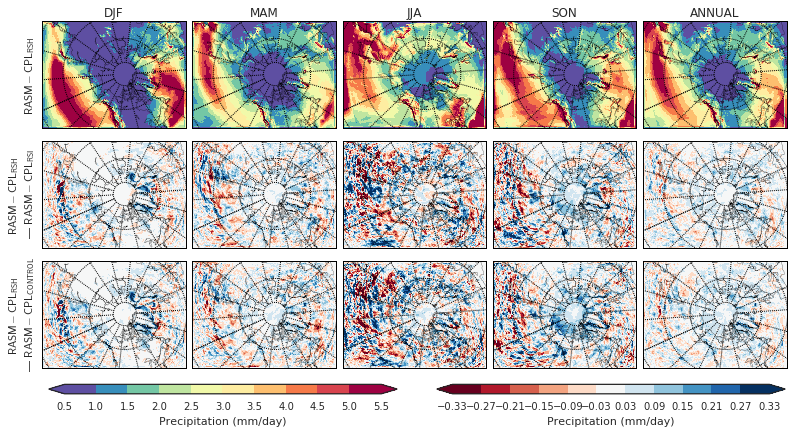

In [113]:
monthly_means = OrderedDict()
for sim in rasm_cpl_sims[::-1]:
    da = (ncdata[sim]['a2xavg_Faxa_rainc']
          + ncdata[sim]['a2xavg_Faxa_rainl']
          + ncdata[sim]['a2xavg_Faxa_snowc']
          + ncdata[sim]['a2xavg_Faxa_snowl'])
    monthly_means[sim] = da.sel(time=slice(start, end)) * 86400

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0.5, vmax=5.5, amin=-.33, amax=.33,
                   annual_means=True,
                   cbar_label='Precipitation (mm/day)',
                   abar_label='Precipitation (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


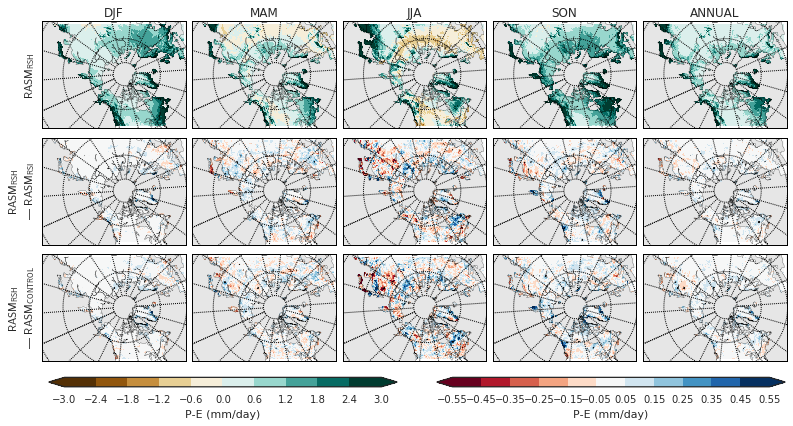

In [17]:
var = 'P-E'

monthly_means = OrderedDict()
for sim in rasm_sims[::-1]:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=-3, vmax=3, amin=-.55, amax=.55,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='P-E (mm/day)',
                   abar_label='P-E (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', cmap='BrBG', amap='RdBu', mask_sig=0.3)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


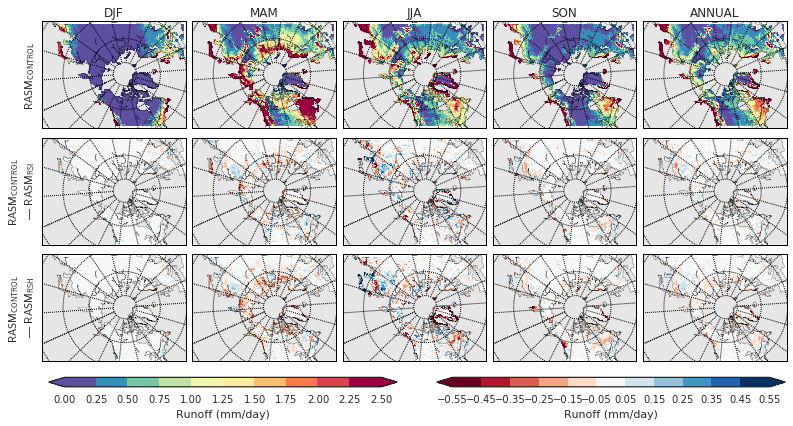

In [18]:
var = 'runoff_tot'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=2.5, amin=-.55, amax=.55,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Runoff (mm/day)',
                   abar_label='Runoff (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu', mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_07.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


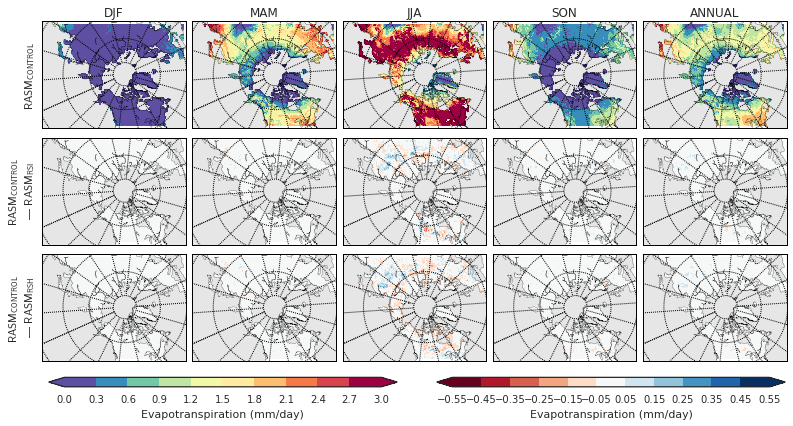

In [19]:
var = 'Evap'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=3, amin=-.55, amax=.55,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Evapotranspiration (mm/day)',
                   abar_label='Evapotranspiration (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu', mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


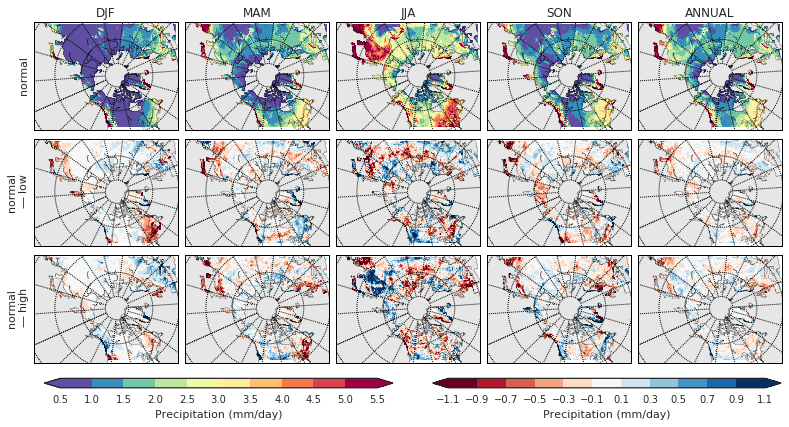

In [111]:
monthly_means = OrderedDict()
sim = '$RASM-CPL_{CONTROL}$'

da = (ncdata[sim]['a2xavg_Faxa_rainc']
      + ncdata[sim]['a2xavg_Faxa_rainl']
      + ncdata[sim]['a2xavg_Faxa_snowc']
      + ncdata[sim]['a2xavg_Faxa_snowl'])

da = da.sel(time=slice(start, end)) * 86400

for name, years in prec_years.items():
    monthly_means[name] = da.sel(time=np.in1d(da.indexes['time'].year, years))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0.5, vmax=5.5, amin=-1.1, amax=1.1,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Precipitation (mm/day)',
                   abar_label='Precipitation (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


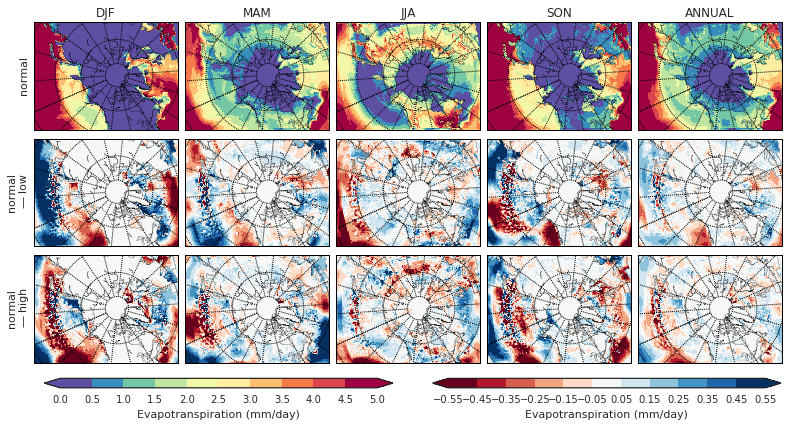

In [112]:
var = 'x2aavg_Faxx_evap'
monthly_means = OrderedDict()

sim = '$RASM-CPL_{CONTROL}$'

da = ncdata[sim][var].sel(time=slice(start, end)) * -1 * 86400

for name, years in prec_years.items():
    monthly_means[name] = da.sel(time=np.in1d(da.indexes['time'].year, years))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=5, amin=-.55, amax=.55,
#                    mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Evapotranspiration (mm/day)',
                   abar_label='Evapotranspiration (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu', mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


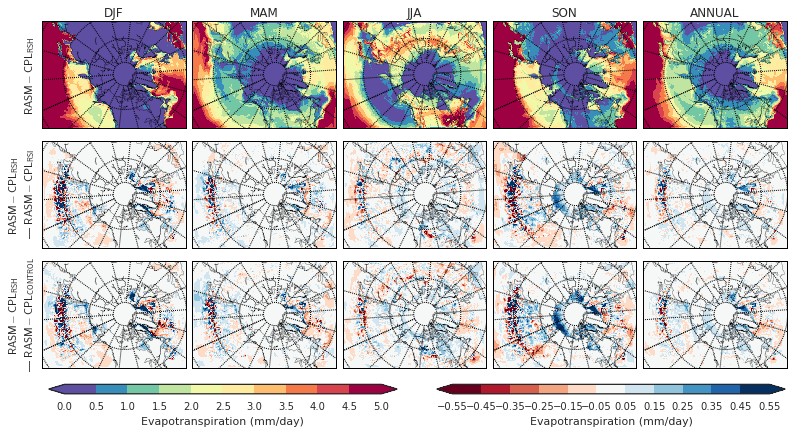

In [85]:
var = 'x2aavg_Faxx_evap'
monthly_means = OrderedDict()
for sim in rasm_cpl_sims[::-1]:
    da = ncdata[sim][var].sel(time=slice(start, end)) * -1 * 86400
    monthly_means[sim] = da.sel(time=np.in1d(da.indexes['time'].year, prec_years['low']))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=5, amin=-.55, amax=.55,
#                    mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Evapotranspiration (mm/day)',
                   abar_label='Evapotranspiration (mm/day)',
                   cbar_extend='both',
                   abar_extend='both', amap='RdBu', mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


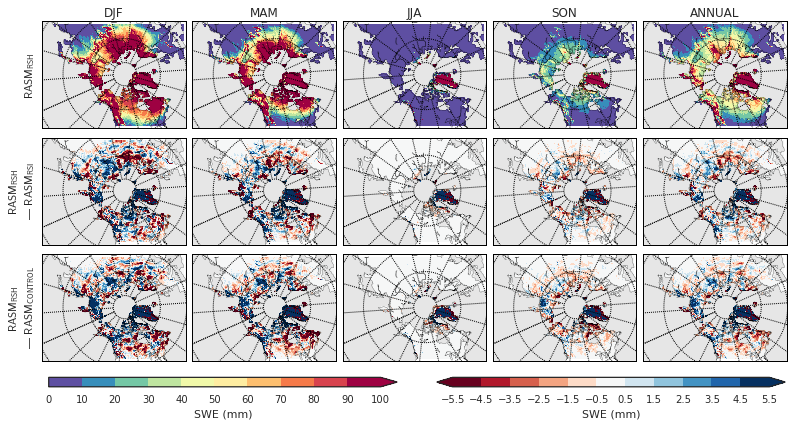

In [19]:
var = 'Swq'
monthly_means = OrderedDict()
for sim in rasm_sims[::-1]:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts3'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=100, amin=-5.5, amax=5.5,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='SWE (mm)',
                   abar_label='SWE (mm)',
                   cbar_extend='max',
                   abar_extend='both',
                   amap='RdBu',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_07.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


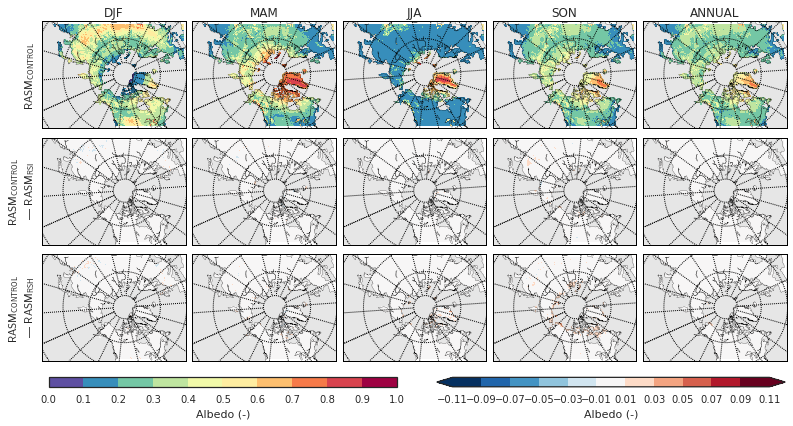

In [43]:
var = 'calc_albedo'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var]
# monthly_means['GlobAlbedo'] = ncdata['globalbedo_monthly_ts'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=1., amin=-0.11, amax=0.11,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Albedo (-)',
                   abar_label='Albedo (-)',
                   cbar_extend='neither',
                   abar_extend='both',
                   mask_sig=None)


# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


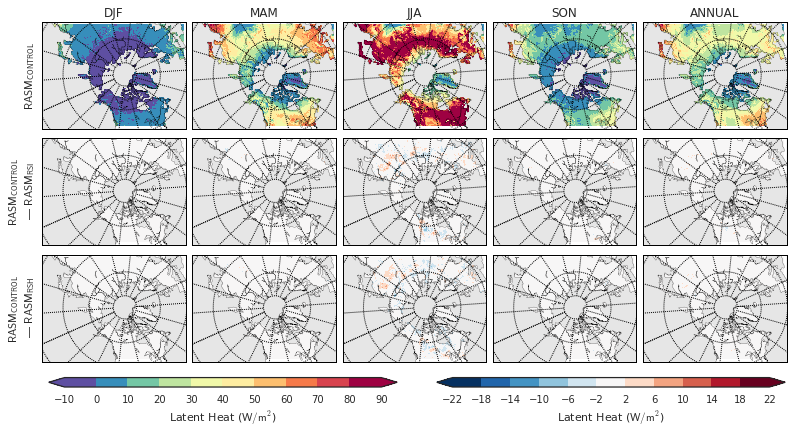

In [44]:
var = 'Latht'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['J2011'] = ncdata['gfluxnet_monthly_ts'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=-10, vmax=90,
                   amin=-22, amax=22,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Latent Heat ($W/m^2$)',
                   abar_label='Latent Heat ($W/m^2$)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_05.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


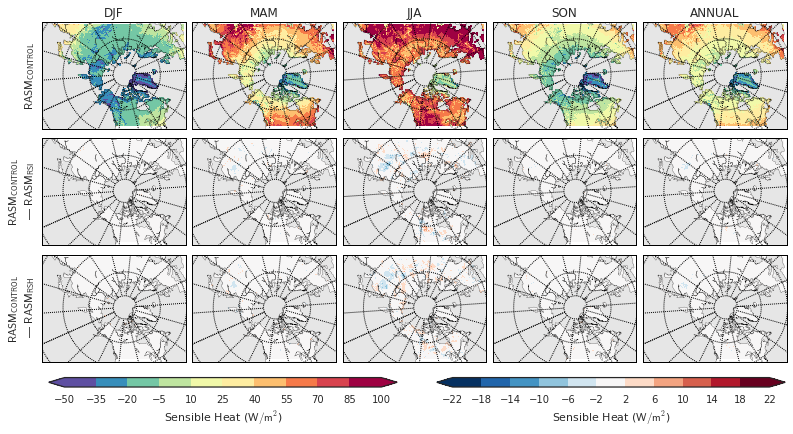

In [45]:
var = 'Senht'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['J2011'] = ncdata['gfluxnet_monthly_ts'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=-50, vmax=100,
                   amin=-22, amax=22,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Sensible Heat ($W/m^2$)',
                   abar_label='Sensible Heat ($W/m^2$)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_06.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


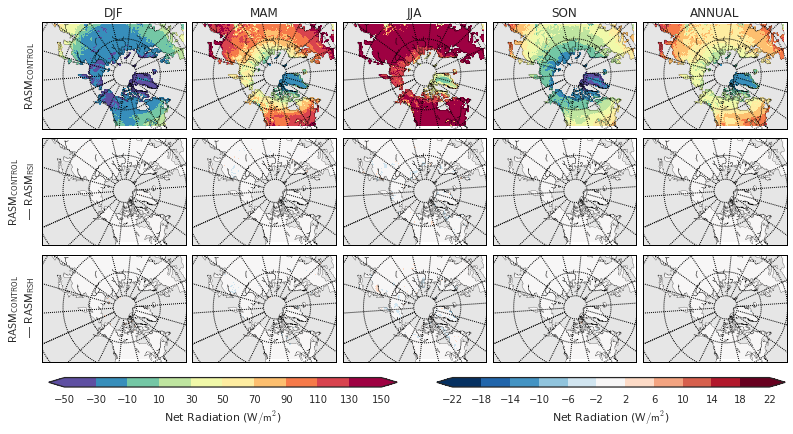

In [47]:
var = 'Radnet'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts1'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=-50, vmax=150,
                   amin=-22, amax=22,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Net Radiation ($W/m^2$)',
                   abar_label='Net Radiation ($W/m^2$)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_05.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


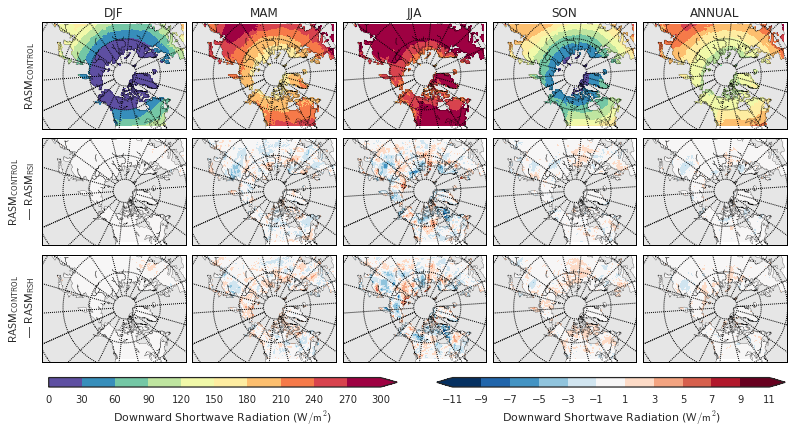

In [50]:
var = 'Swin'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var]

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=300,
                   amin=-11, amax=11,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Downward Shortwave Radiation ($W/m^2$)',
                   abar_label='Downward Shortwave Radiation ($W/m^2$)',
                   cbar_extend='max',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_01.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


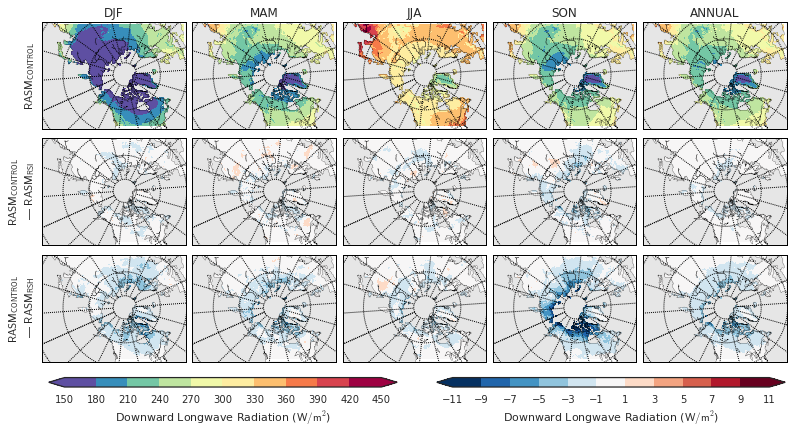

In [54]:
var = 'Lwin'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var]

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=150, vmax=450,
                   amin=-11, amax=11,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Downward Longwave Radiation ($W/m^2$)',
                   abar_label='Downward Longwave Radiation ($W/m^2$)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_03.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


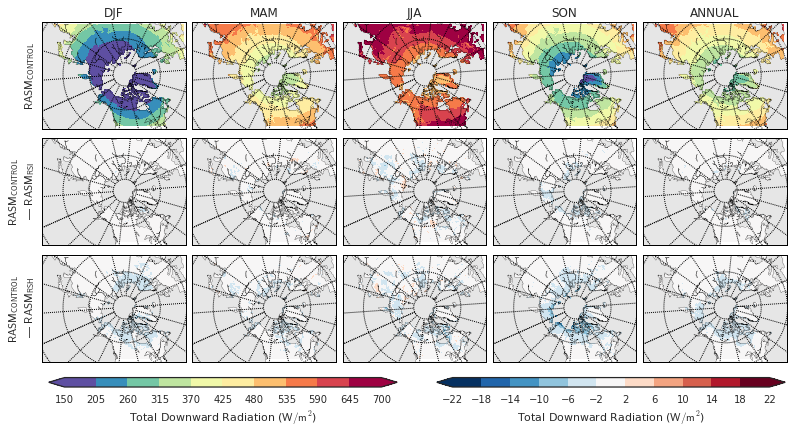

In [52]:
var = 'Radin'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var]

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=150, vmax=700,
                   amin=-22, amax=22,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Total Downward Radiation ($W/m^2$)',
                   abar_label='Total Downward Radiation ($W/m^2$)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_04.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


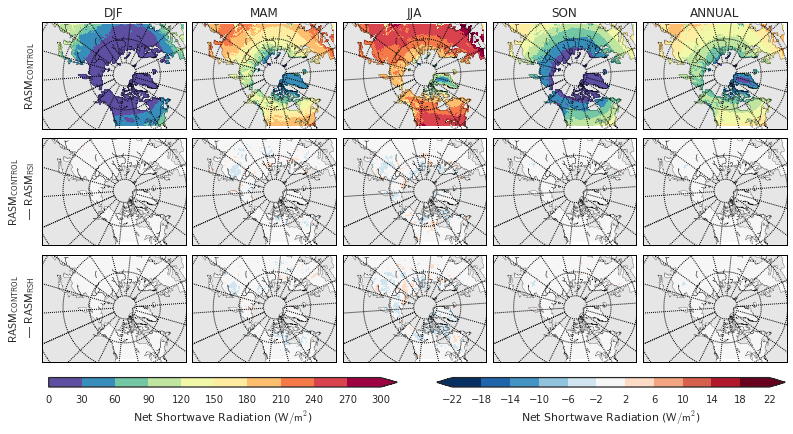

In [55]:
var = 'Swnet'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var].sel(time=slice(start, end))

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=300,
                   amin=-22, amax=22,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Net Shortwave Radiation ($W/m^2$)',
                   abar_label='Net Shortwave Radiation ($W/m^2$)',
                   cbar_extend='max',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Figure_04.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


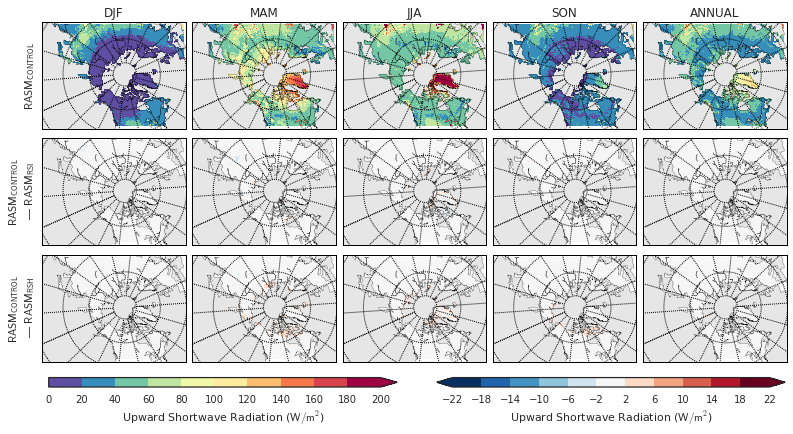

In [56]:
var = 'Swup'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var]

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=0, vmax=200,
                   amin=-22, amax=22,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Upward Shortwave Radiation ($W/m^2$)',
                   abar_label='Upward Shortwave Radiation ($W/m^2$)',
                   cbar_extend='max',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_02.png'), dpi=dpi, bbox_inches='tight')

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


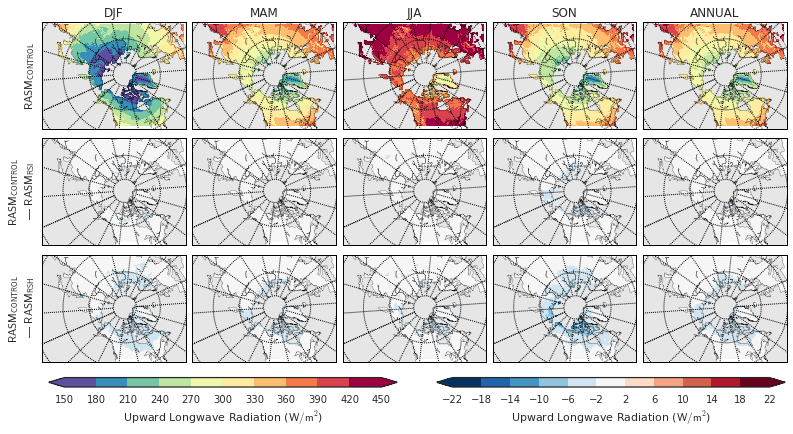

In [57]:
var = 'Lwup'
monthly_means = OrderedDict()
for sim in rasm_sims:
    monthly_means[sim] = ncdata[sim][var].sel(time=slice(start, end))
# monthly_means['ERA'] = ncdata['era_monthly_ts1'][var].sel(time=slice(start, end))
# monthly_means['MERRA'] = ncdata['merra_monthly_ts2'][var]

sns.set_style("white")
fig, axes = plot_n(monthly_means,
                   vmin=150, vmax=450,
                   amin=-22, amax=22,
                   mask=spatial_plot_mask,
                   annual_means=True,
                   cbar_label='Upward Longwave Radiation ($W/m^2$)',
                   abar_label='Upward Longwave Radiation ($W/m^2$)',
                   cbar_extend='both',
                   abar_extend='both',
                   mask_sig=None)

# plt.savefig('rasm1_plot_spatial_{}.png'.format(var), dpi=dpi, bbox_inches='tight')
# plt.savefig(os.path.join(os.environ['FTP'], 'RASM_land_surface_climate_figures', 'Supmat_04.png'), dpi=dpi, bbox_inches='tight')